In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# =====================================
# INSTALL + IMPORTS
# =====================================
!pip install -q transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
import evaluate

In [ ]:
# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Project/data.csv")

In [ ]:
# Clean
df['sentence'] = df['sentence'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()
df['label'] = df['label'].astype(float).astype(int)

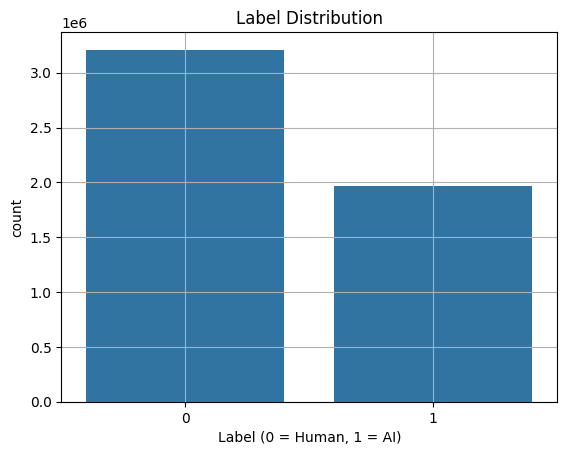

In [ ]:
# Plot label distribution
sns.countplot(data=df, x='label')
plt.title("Label Distribution")
plt.xlabel("Label (0 = Human, 1 = AI)")
plt.grid(True)
plt.show()

In [ ]:
# Downsample for faster testing (remove for full training)
df = df.groupby("label").apply(lambda x: x.sample(n=min(5000, len(x)))).reset_index(drop=True)

<ipython-input-11-5bcbc8ba069a>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("label").apply(lambda x: x.sample(n=min(5000, len(x)))).reset_index(drop=True)


In [ ]:
# =====================================
# 3. SPLIT + TOKENIZE
# =====================================
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# Convert to HF Dataset (only sentence + label)
train_dataset = Dataset.from_pandas(train_df[["sentence", "label"]])
test_dataset = Dataset.from_pandas(test_df[["sentence", "label"]])
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})


In [ ]:
 #Tokenize
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize_fn(example):
    return tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["sentence"])
tokenized_dataset.set_format("torch")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# =====================================
# METRICS
# =====================================
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
    }


In [ ]:
# =====================================
# TRAINING SETUP
# =====================================
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

training_args = TrainingArguments(
    output_dir="./bert_detector",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=1,
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to="none",
    seed=42
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-16-af08876ff382>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# =====================================
# 6. TRAIN MODEL
# =====================================
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.267100,0.284220,0.881000,0.883789,0.863550,0.905000
2,0.220000,0.757723,0.798500,0.829165,0.719647,0.978000
3,0.060400,0.522804,0.879500,0.885402,0.844062,0.931000
4,0.020800,0.631921,0.880500,0.887423,0.838825,0.942000


TrainOutput(global_step=2000, training_loss=0.1815540407449007, metrics={'train_runtime': 787.2692, 'train_samples_per_second': 40.647, 'train_steps_per_second': 2.54, 'total_flos': 2104888442880000.0, 'train_loss': 0.1815540407449007, 'epoch': 4.0})

In [ ]:
# =====================================
# EVALUATION & METRICS
# =====================================
preds_output = trainer.predict(tokenized_dataset["test"])
y_true = preds_output.label_ids
y_probs = torch.nn.functional.softmax(torch.tensor(preds_output.predictions), dim=1)[:, 1].numpy()
y_pred = np.argmax(preds_output.predictions, axis=1)


Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1000
           1       0.84      0.94      0.89      1000

    accuracy                           0.88      2000
   macro avg       0.89      0.88      0.88      2000
weighted avg       0.89      0.88      0.88      2000



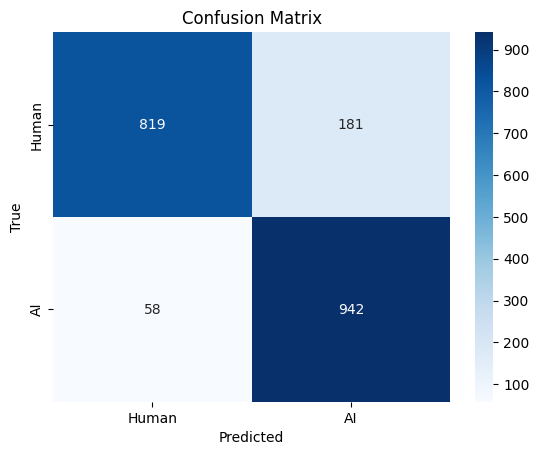

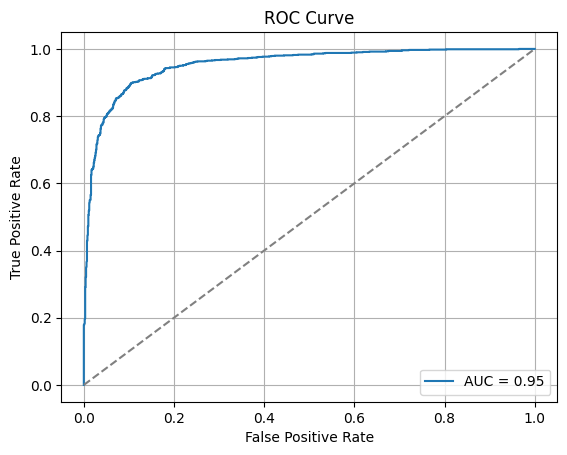

In [ ]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

# Confusion Matrix
conf = confusion_matrix(y_true, y_pred)
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
auc = roc_auc_score(y_true, y_probs)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# =====================================
# SAVE MODEL + TOKENIZER
# =====================================
model.save_pretrained("/content/drive/MyDrive/Project/Output/bert_detector")
tokenizer.save_pretrained("/content/drive/MyDrive/Project/Output/bert_detector")

('/content/drive/MyDrive/Project/Output/bert_detector/tokenizer_config.json',
 '/content/drive/MyDrive/Project/Output/bert_detector/special_tokens_map.json',
 '/content/drive/MyDrive/Project/Output/bert_detector/vocab.txt',
 '/content/drive/MyDrive/Project/Output/bert_detector/added_tokens.json',
 '/content/drive/MyDrive/Project/Output/bert_detector/tokenizer.json')

In [ ]:
from transformers import BertTokenizerFast, BertForSequenceClassification

model_path = "/content/drive/MyDrive/Project/Output/bert_detector"

# Load tokenizer and model (this works for local folders)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model = model.to(device)
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
import torch
import numpy as np

def predict(texts):
    # Tokenize input text
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)

    # Forward pass, get logits
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Apply softmax to get probabilities
    probs = torch.nn.functional.softmax(logits, dim=-1)

    # Get predicted class (0 or 1)
    preds = torch.argmax(probs, dim=-1)

    return preds.cpu().numpy(), probs.cpu().numpy()

In [ ]:
predict("This is a sampel text")

(array([0]), array([[0.954667  , 0.04533305]], dtype=float32))

In [ ]:
texts = ["This is a sample text"]

predictions, probabilities = predict(texts)

for text, pred, prob in zip(texts, predictions, probabilities):
    label = "Human" if pred == 0 else "AI"
    print(f"Text: {text}")
    print(f"Predicted Label: {label}")
    print(f"Probabilities: Human={prob[0]:.2%}, AI={prob[1]:.2%}")
    print("="*50)


Text: This is a sample text
Predicted Label: Human
Probabilities: Human=99.56%, AI=0.44%
